# Parameter Distortion Robustness Analysis

Analysis of model performance degradation under parameter distortion for Section 4, Experiment 01

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
SAVE_RESULT_PATH = config["SAVE_RESULT_PATH"]

In [3]:
notebook_name = 'robustness-parameter-distortion'
exp_number = '01'
section_number = '4'
version_number = 'v1'
notebook_path = f'{SAVE_RESULT_PATH}/{exp_number}_{version_number}_{notebook_name}'
notebook_config = {
    'notebook_name': notebook_name,
    'exp_number': exp_number,
    'version_number': version_number,
    'section_number': section_number
}

## Load Data using Sequential Re-assembly

Load the pre-generated parameter distortion results using the batch framework's re-assembly pattern

In [4]:
from scripts.batch_framework import create_batch_executor
from models.utils.s3_config_manager import S3ConfigManager
import pandas as pd

# Initialize S3 manager
s3_manager = S3ConfigManager()
print("✅ S3 connection established")

# Create batch executor for re-assembly
batch_executor = create_batch_executor(
    notebook_name='batch-parameter-distortion',
    exp_number='01',
    version_number='v1',
    section_number='4'
)

# Load data using sequential re-assembly
try:
    distortion_results = batch_executor.sequential_reassembly('parameter_distortion_results')
    print(f"✅ Loaded re-assembled parameter distortion results: {len(distortion_results)} data points")
    print(f"Data shape: {distortion_results.shape}")
    if not distortion_results.empty:
        print(f"Distortion factors: {distortion_results['Distortion Factor'].unique()}")
except Exception as e:
    print(f"❌ Re-assembly failed: {e}")
    # Create empty dataframe for fallback analysis
    distortion_results = pd.DataFrame()

✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established
✅ S3 connection successful. Bucket: bio-data


Cleaned assembly list: removed 6 duplicate entries


Uploading v1_assembly_list.csv: 100%|██████████| 216/216 [00:00<00:00, 1.99kB/s]

Re-assembled 5 data files into DataFrame with shape (1250, 9)
✅ Loaded re-assembled parameter distortion results: 1250 data points
Data shape: (1250, 9)
Distortion factors: [3.  2.  1.5 1.3 1.1]


In [5]:
# Preview the data
if not distortion_results.empty:
    print("Data Preview:")
    print(distortion_results.head())
    print("\nColumns:", distortion_results.columns.tolist())

Data Preview:
               Model  Feature Data  Mean Squared Error  R2 Score  \
0  Linear Regression  feature_data          619.137916  0.051849   
1  Linear Regression  feature_data          101.311283  0.022694   
2  Linear Regression  feature_data          137.799991  0.053233   
3  Linear Regression  feature_data          276.122510  0.110802   
4  Linear Regression  feature_data          557.647686  0.040062   

   Pearson Correlation  Pearson P-Value  Distortion Factor Assembly ID  \
0             0.303865     1.218561e-05                3.0         3.0   
1             0.266343     1.377687e-04                3.0         3.0   
2             0.268102     1.239017e-04                3.0         3.0   
3             0.353225     2.891501e-07                3.0         3.0   
4             0.217104     2.015156e-03                3.0         3.0   

                    Timestamp  
0  2025-12-28T05:36:54.241981  
1  2025-12-28T05:36:54.241981  
2  2025-12-28T05:36:54.241981  
3  2

## Data Summary

In [6]:
import pandas as pd
import numpy as np

if not distortion_results.empty:
    # Summary statistics by distortion factor
    stats_summary = distortion_results.groupby('Distortion Factor').agg({
        'Pearson Correlation': ['mean', 'std', 'min', 'max'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Summary Statistics by Distortion Factor:")
    print(stats_summary)
    
    # Model performance comparison
    model_stats = distortion_results.groupby(['Model', 'Distortion Factor'])['Pearson Correlation'].mean().unstack()
    print("\nModel Performance (Average Pearson Correlation):")
    print(model_stats.round(3))

Summary Statistics by Distortion Factor:
                  Pearson Correlation                      R2 Score          \
                                 mean    std    min    max     mean     std   
Distortion Factor                                                             
1.1                             0.700  0.319 -0.004  0.993   -1.562   8.517   
1.3                             0.593  0.253  0.008  0.941   -1.815   8.584   
1.5                             0.520  0.232 -0.082  0.862   -1.980   8.797   
2.0                             0.450  0.194 -0.109  0.788   -2.464  10.417   
3.0                             0.381  0.170 -0.104  0.779   -2.432   9.870   

                  Mean Squared Error            
                                mean       std  
Distortion Factor                               
1.1                          634.113  1688.568  
1.3                          709.159  1680.418  
1.5                          764.277  1692.604  
2.0                          874

## Visualizations

Create visualizations showing performance degradation across distortion levels

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from models.utils.s3_config_manager import S3ConfigManager

# Set up plotting style for publication quality
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(font="Arial", font_scale=1.5)

C:\Users\l8105\AppData\Local\Temp\ipykernel_16900\3420470943.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=distortion_results, x='Distortion Factor', y='Pearson Correlation',
Uploading v1_parameter_distortion_overview.png: 100%|██████████| 96.5k/96.5k [00:00<00:00, 383kB/s]


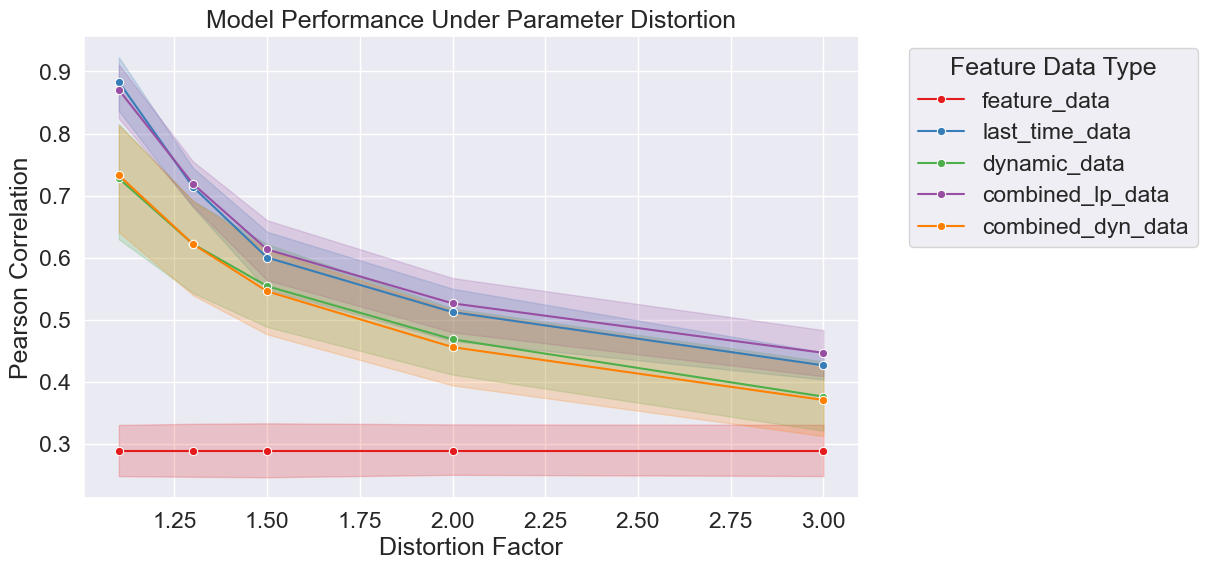

In [8]:
if not distortion_results.empty:
    # Line plot for Pearson Correlation vs Distortion Factor
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=distortion_results, x='Distortion Factor', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Parameter Distortion')
    plt.xlabel('Distortion Factor')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "parameter_distortion_overview")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_16900\1498221545.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=filtered_data, x='Distortion Factor', y='Pearson Correlation',
Uploading v1_parameter_distortion_zoomed.png: 100%|██████████| 92.1k/92.1k [00:00<00:00, 409kB/s]


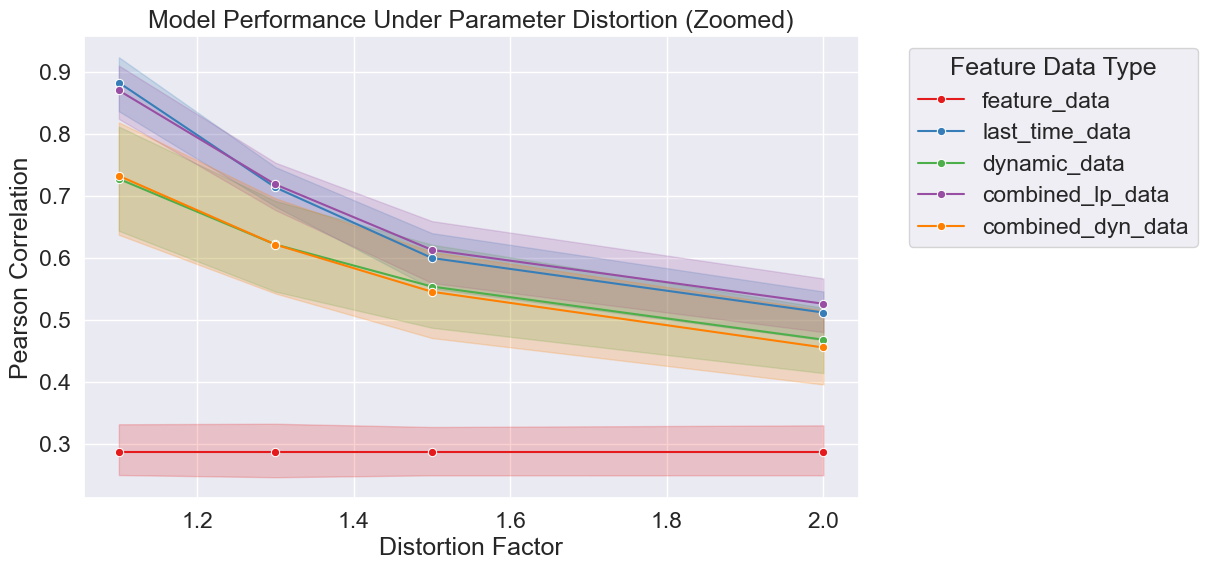

In [9]:
if not distortion_results.empty:
    # Zoomed view for lower distortion factors
    plt.figure(figsize=(10, 6))
    filtered_data = distortion_results[distortion_results['Distortion Factor'] <= 2.0]
    sns.lineplot(data=filtered_data, x='Distortion Factor', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Parameter Distortion (Zoomed)')
    plt.xlabel('Distortion Factor')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "parameter_distortion_zoomed")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_16900\4138429701.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=distortion_results, x='Distortion Factor', y='Pearson Correlation',
Uploading v1_model_comparison_distortion.png: 100%|██████████| 120k/120k [00:00<00:00, 540kB/s]


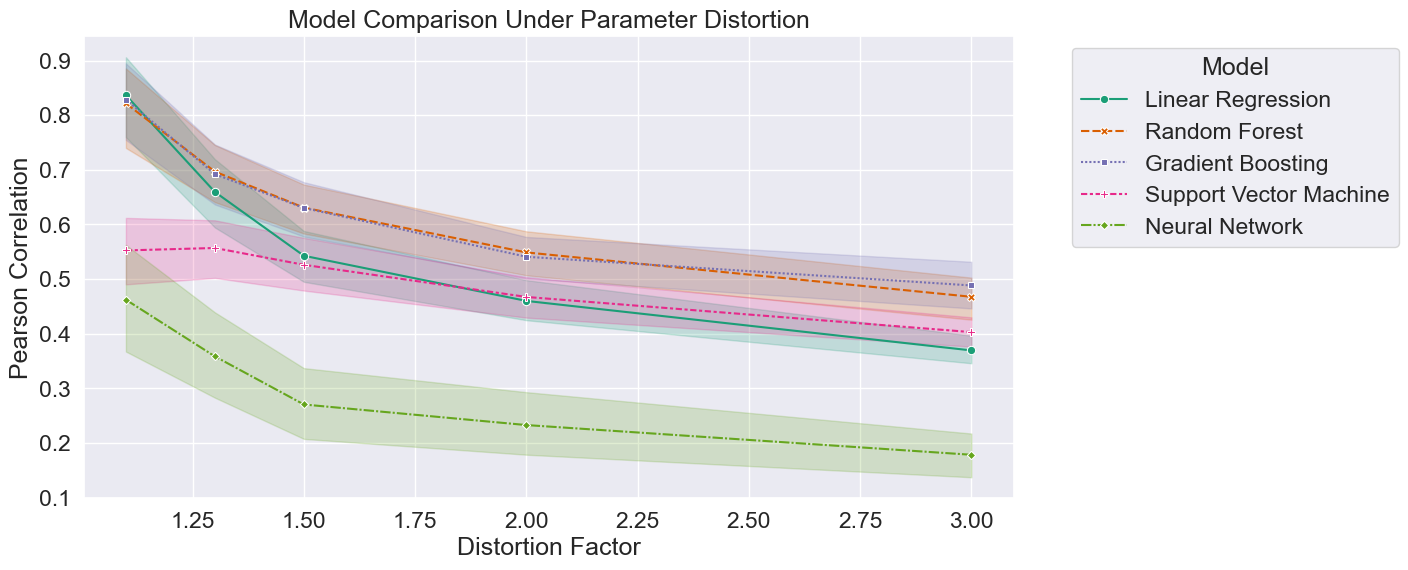

In [10]:
if not distortion_results.empty:
    # Model comparison across distortion levels
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=distortion_results, x='Distortion Factor', y='Pearson Correlation', 
                 hue='Model', style='Model', palette='Dark2', markers=True, ci=95)
    plt.title('Model Comparison Under Parameter Distortion')
    plt.xlabel('Distortion Factor')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "model_comparison_distortion")
    plt.show()

Uploading v1_performance_distribution_distortion.png: 100%|██████████| 46.0k/46.0k [00:00<00:00, 259kB/s]


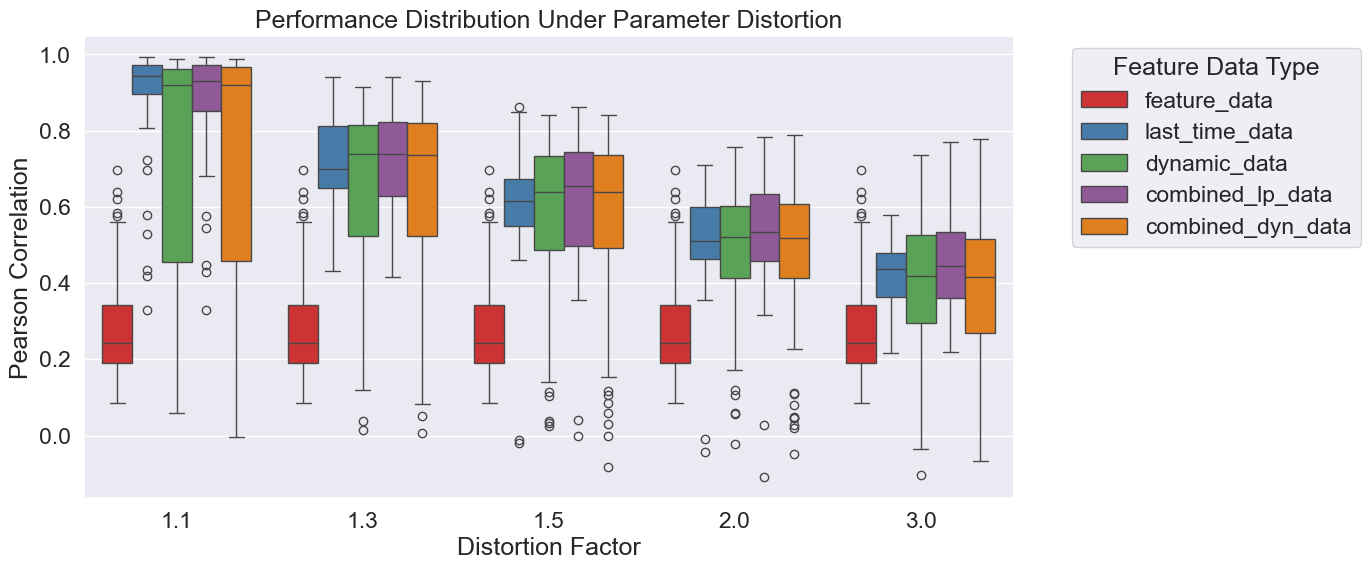

In [11]:
if not distortion_results.empty:
    # Boxplot showing performance distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=distortion_results, x='Distortion Factor', y='Pearson Correlation', 
                hue='Feature Data', palette='Set1')
    plt.title('Performance Distribution Under Parameter Distortion')
    plt.xlabel('Distortion Factor')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "performance_distribution_distortion")
    plt.show()

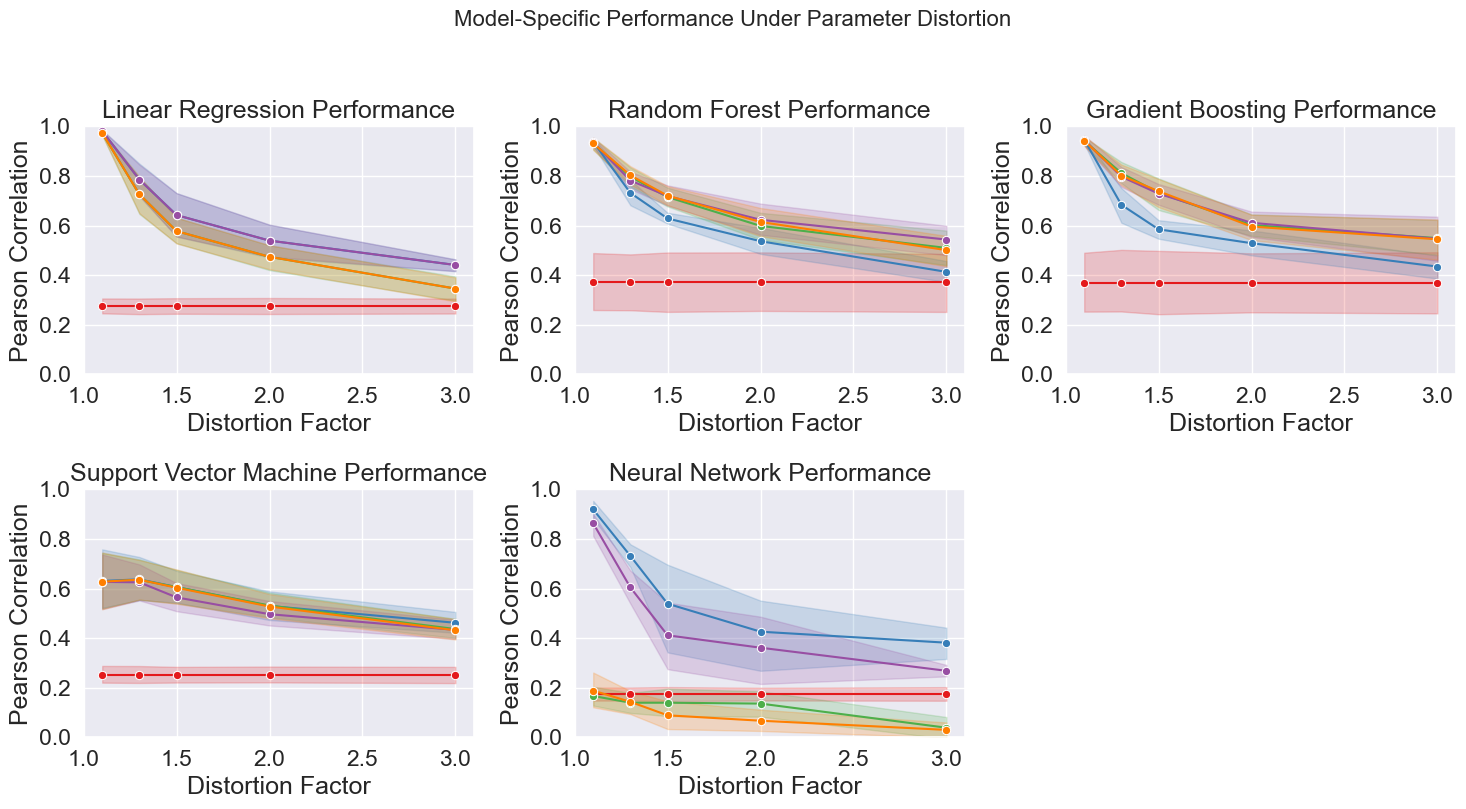

In [31]:
if not distortion_results.empty:
    # Get unique models
    models = distortion_results["Model"].unique()
    feature_data_types = distortion_results["Feature Data"].unique()
    
    n_models = len(models)

    # Calculate grid dimensions
    n_cols = min(3, n_models)  # Max 3 columns
    n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(
        "Model-Specific Performance Under Parameter Distortion", fontsize=16, y=1.02
    )

    # Flatten axes array for easy iteration
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create plot for each model
    for i, model in enumerate(models):
        ax = axes[i]
        model_data = distortion_results[distortion_results["Model"] == model]

        sns.lineplot(
            data=model_data,
            x="Distortion Factor",
            y="Pearson Correlation",
            hue="Feature Data",
            palette="Set1",
            marker="o",
            ax=ax,
        )

        ax.set_title(f"{model} Performance")
        ax.set_xlabel("Distortion Factor")
        ax.set_ylabel("Pearson Correlation")
        
        # ensure identical x and y limits across all subplots, x is between 0 and 3 
        # y is between 0 and 1
        ax.set_xlim(1, 3.1)
        ax.set_ylim(0, 1)
        
        # no legend to avoid clutter, unless it is the last plot 
        ax.legend().remove()
        
        # if i == n_models - 1:
        #     ax.legend(title="Feature Data", bbox_to_anchor=(1.05, 1), loc="upper left")
        # else:
        #     ax.legend().remove()
        

    # Hide any unused subplots
    for i in range(len(models), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()

    # Save to S3
    # s3_manager.save_figure(notebook_config, fig, "model_specific_distortion_analysis")
    plt.show()

## Statistical Analysis

In [12]:
if not distortion_results.empty:
    # Calculate performance degradation
    baseline_performance = distortion_results[distortion_results['Distortion Factor'] == 0]
    distorted_performance = distortion_results[distortion_results['Distortion Factor'] > 0]
    
    if not baseline_performance.empty and not distorted_performance.empty:
        # Average baseline performance
        baseline_mean = baseline_performance['Pearson Correlation'].mean()
        print(f"Baseline performance (no distortion): {baseline_mean:.3f}")
        
        # Performance at different distortion levels
        for factor in sorted(distortion_results['Distortion Factor'].unique()):
            if factor > 0:
                factor_data = distortion_results[distortion_results['Distortion Factor'] == factor]
                factor_mean = factor_data['Pearson Correlation'].mean()
                degradation = baseline_mean - factor_mean
                degradation_pct = (degradation / baseline_mean) * 100
                print(f"Distortion {factor}: {factor_mean:.3f} (degradation: {degradation:.3f}, {degradation_pct:.1f}%)")
    
    # Statistical significance testing between feature data types
    from scipy import stats
    
    print("\nFeature Data Type Comparison (Pearson Correlation):")
    feature_types = distortion_results['Feature Data'].unique()
    for i, type1 in enumerate(feature_types):
        for type2 in feature_types[i+1:]:
            data1 = distortion_results[distortion_results['Feature Data'] == type1]['Pearson Correlation']
            data2 = distortion_results[distortion_results['Feature Data'] == type2]['Pearson Correlation']
            t_stat, p_value = stats.ttest_ind(data1, data2)
            print(f"{type1} vs {type2}: t={t_stat:.3f}, p={p_value:.4f}")


Feature Data Type Comparison (Pearson Correlation):
feature_data vs last_time_data: t=-20.957, p=0.0000
feature_data vs dynamic_data: t=-13.192, p=0.0000
feature_data vs combined_lp_data: t=-21.164, p=0.0000
feature_data vs combined_dyn_data: t=-12.696, p=0.0000
last_time_data vs dynamic_data: t=3.542, p=0.0004
last_time_data vs combined_lp_data: t=-0.420, p=0.6746
last_time_data vs combined_dyn_data: t=3.673, p=0.0003
dynamic_data vs combined_lp_data: t=-3.875, p=0.0001
dynamic_data vs combined_dyn_data: t=0.172, p=0.8633
combined_lp_data vs combined_dyn_data: t=4.000, p=0.0001


## Performance Metrics Summary

In [13]:
if not distortion_results.empty:
    # Create a comprehensive performance summary table
    performance_summary = distortion_results.groupby(['Distortion Factor', 'Model', 'Feature Data']).agg({
        'Pearson Correlation': ['mean', 'std', 'count'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Performance Summary Table:")
    print(performance_summary)

Performance Summary Table:
                                                           Pearson Correlation  \
                                                                          mean   
Distortion Factor Model                  Feature Data                            
1.1               Gradient Boosting      combined_dyn_data               0.943   
                                         combined_lp_data                0.945   
                                         dynamic_data                    0.942   
                                         feature_data                    0.367   
                                         last_time_data                  0.947   
...                                                                        ...   
3.0               Support Vector Machine combined_dyn_data               0.432   
                                         combined_lp_data                0.433   
                                         dynamic_data                  

## Save Analysis Results

In [14]:
# Save the summary statistics and analysis results
if not distortion_results.empty:
    # Save the filtered summary table
    simplified_summary = distortion_results.groupby(['Distortion Factor', 'Feature Data'])['Pearson Correlation'].agg(['mean', 'std', 'count']).round(3)
    
    try:
        s3_manager.save_data(notebook_config, simplified_summary, 'parameter_distortion_summary', data_format='csv')
        print("✅ Saved analysis summary to S3")
    except Exception as e:
        print(f"❌ Error saving summary: {e}")

Uploading v1_parameter_distortion_summary.csv: 100%|██████████| 407/407 [00:00<00:00, 2.70kB/s]

✅ Saved analysis summary to S3


## Conclusion

This analysis demonstrates the robustness of the models under parameter distortion. Key findings:

1. **Performance degradation pattern** with increasing distortion factors
2. **Comparison of feature data types** for robustness
3. **Model-specific sensitivity** to parameter perturbations

The visualizations and statistical analysis provide insights into the system's tolerance to parameter variability.